# Setup

In [2]:
import itertools
import math
import time
import os
import json
from collections import defaultdict
from tqdm.auto import tqdm

import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
from sklearn import svm, linear_model, neural_network, pipeline, preprocessing, base

# ignore convergence warnings from sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
DEV = False

# define environment constants
COLAB = 0
ADROIT = 1
EULER = 2
ENV = COLAB

# set environment settings
if ENV == COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  
  OUTPUT_DIR = "/content/results"
  EXPERIMENT_BATCH_ID = None
elif ENV == ADROIT:
  import argparse
  parser = argparse.ArgumentParser()
  parser.add_argument("-o", "--out", help="specify output directory")
  parser.add_argument("-b", "--batch", help="specify experiment batch number", type=int)
  
  args = parser.parse_args()
  OUTPUT_DIR = args.out
  EXPERIMENT_BATCH_ID = args.batch

def json_serialize(obj):
  """
  Convert some non-serializable types into serializable ones to be stored in JSON format
  """
  if isinstance(obj, np.integer):
    return int(obj)
  if isinstance(obj, np.floating):
    return float(obj)
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  if isinstance(obj, base.BaseEstimator):
    return obj.__class__.__name__
  return json.JSONEncoder().default(obj)

Mounted at /content/drive/


# Code base

## Definition of Shapley values
$$
s_i := \mathbb{E}_{\pi} [U(\pi_{\leq i}) - U(\pi_{< i})]
$$

## Computing Shapley values

**Approach 1**: sum marginal utilities over all possible permutations
$$
s_i = \frac{1}{n!} \sum_{\pi \in S_n} (U(\pi_{\leq i}) - U(\pi_{< i})) \text{ for all } i \in [n]
$$
- number of iterations: $n \cdot n! \in \Theta(n^{n+1})$
- number of utility evaluations (without memoization): $n \cdot n! \in \Theta(n^{n+1})$
- number of utility evaluations (with memoization): $\Theta(2^n)$ with $\Theta(2^n)$ space complexity

**Approach 2**: sum marginal utilities over all possible subsets weighted by probability of $S$ (i.e. $n$ possibilities for choosing $|S|$ and $\binom{n-1}{|S|}$ possibilities for choosing $S$)
$$
s_i = \sum_{S \subseteq [n] \setminus \{i\}} \frac{1}{n\binom{n-1}{|S|}}(U(S \cup \{i\}) - U(S)) \text{ for all } i \in [n]
$$
- number of iterations: $\Theta(n \cdot 2^n)$
- number of utility evaluations (with memoization): $\Theta(2^n)$ with $\Theta(2^n)$ space complexity

## Approximating Shapley values
...

## Class: Dataset

In [4]:
class Dataset():
  def __init__(self, dataset, indices=None):
    """
    Initialize wrapper class for dataset

    Args:
      dataset: list of (x, label)
      indices: list of indices, otherwise indices autogenerated if not given
    """
    self.dataset = dataset
    self.size = len(self.dataset)
    if indices is None:
      self.indices = list(range(self.size))
    else:
      self.indices = indices
  
  def __call__(self, indices, complement=False):
    """
    Create a dataset with a subset of datapoints according to the specified indices

    Args:
      indices: list of indices
      complement: boolean flag whether given list of indices should be included or excluded
    Returns:
      sub_dataset: Dataset object with a sublist of datapoints
    """
    if complement:
      indices = self.complement_indices(indices)
    sub_dataset = Dataset([self.dataset[i] for i in indices], indices=indices)
    return sub_dataset
  
  def complement_indices(self, indices):
    return list(set(self.indices) - set(indices))

  def to_matrix_form(self):
    """
    Convert the dataset to a feature matrix and label vector

    Returns:
      X: matrix of features with dimensions (n_samples, n_features)
      y: vector of labels with dimensions (n_samples)
    """
    n_samples = len(self.dataset)
    n_features = len(self.dataset[0][0])
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples)
    for i, (x, label) in enumerate(self.dataset):
      X[i,:] = x
      y[i] = label
    return X, y
  
  def save_dataset(self, folder, filename="dataset"):
    """
    Save the dataset in JSON format

    Args:
      folder: path to folder 
      filename: name of file
    """
    filepath = os.path.join(folder, filename)
    with open("{}.json".format(filepath), "w") as file:
      json.dump(self.dataset, file, indent=2, default=json_serialize)
  
  def get_params(self):
    """
    Return all relevant parameters for this class required for reproducability

    Returns:
      dictionary with all relevant parameters
    """
    return {}

  @staticmethod
  def from_json(folder, filename="dataset"):
    filepath = os.path.join(folder, filename)
    with open("{}.json".format(filepath), "r") as file:
      dataset = json.load(file)
    return Dataset(dataset)

## Class: Utility

In [5]:
class Utility():
  def __call__(self, dataset):
    return self.compute_utility(dataset)
  
  def compute_utility(self, dataset):
    """
    Compute the utility of the given datapoints

    Args:
      dataset: object of class Dataset
    Returns:
      utility: utility value of the given datapoints
    """
    pass
  
  def get_params(self):
    """
    Return all relevant parameters for this class required for reproducability

    Returns:
      dictionary with all relevant parameters
    """
    return {}

## Class: DataShapleySolver

In [6]:
class DataShapleySolver():
  def __init__(self, dataset, utility, seed=0):
    """
    Initialize class for computing Shapley values

    Args:
      dataset: object of class Dataset
      utility: object of class Utility
      seed: integer seed used for reproduceability
    """
    self.dataset = dataset
    self.utility = utility
    self.seed = seed

    self.utilities_computed = {}

  def _reset(self, n_evals=None):
    """
    Reset solver before computing Shapley values

    Args:
      n_evals: total number of utility evaluations for the next computation (only required for progress bar)
    """
    self.utility_eval_time = 0
    self.utility_eval_counter = 0
    self.utility_eval_counter_total = 0
    self.utility_eval_counter_pbar = tqdm(total=n_evals, desc="Utility evaluations", mininterval=1)
    self.shapley_values = np.zeros(self.dataset.size)

    if self.seed is not None:
      self.rng = np.random.default_rng(self.seed)
    else:
      self.rng = np.random.default_rng()
  
  # def _reset_memo(self):
  #   """
  #   Reset all computed utilities (must be used after changing dataset indices)
  #   """
  #   self.utilities_computed = {}

  def _utility_wrapper(self, subset_indices, memo=True, statistics=True):
    """
    Wrapper function around the given utility object to apply memoization and to record statistics

    Args:
      subset_indices: list of indices for which utility should be computed
      memo: boolean flag whether to apply memoization
      statistics: boolean flag whether to update statistics
    Returns:
      utility: computed utility for given subset indices
    """
    if statistics:
      self.utility_eval_counter_total += 1
      self.utility_eval_counter_pbar.update(1)
    # return trivial utility
    if len(subset_indices) == 0:
      return 0
    # return memoized utility
    subset_key = tuple(sorted(subset_indices))
    if memo and subset_key in self.utilities_computed:
      return self.utilities_computed[subset_key]
    # compute utility
    start = time.time()
    utility = self.utility(self.dataset(subset_indices))
    end = time.time()
    if statistics:
      self.utility_eval_time += end - start
      self.utility_eval_counter += 1
    # apply memoization (reduce number of utility evaluations) or skip memoization (reduce memory footprint)
    if memo:
      self.utilities_computed[subset_key] = utility
    # return computed utility
    return utility
  
  def _compute_shapley_with_subsets(self, ignore=[], memo=True):
    """
    Compute Shapley values exactly by computing marginal utility for all possible subsets

    Args:
      ignore: list of indices to be ignored when computing Shapley values
      memo: boolean flag whether to apply memoization
    """
    indices = self.dataset.complement_indices(ignore)
    indices_size = len(indices)

    # construct iterator over all subsets S of size 0 to indices_size-1 (last element added later)
    subsets = itertools.chain.from_iterable(
        [itertools.combinations(indices, r) for r in range(indices_size)]
    )
    n_subsets = 2**indices_size - 1
    
    # initialize computation
    self._reset(n_evals=indices_size * 2**indices_size)
    # compute marginal utilities over all subsets
    for S in tqdm(subsets, total=n_subsets, desc="Loop 1", mininterval=1):
      # scan through all data points not in S
      factor = indices_size * scipy.special.binom(indices_size - 1, len(S))
      not_S = [index for index in indices if index not in S]
      for i in tqdm(not_S, desc="Loop 2", mininterval=2, delay=2, disable=len(not_S) < 500, leave=False):
        self.shapley_values[i] += (self._utility_wrapper(list(S) + [i], memo=memo) - self._utility_wrapper(list(S), memo=memo)) / factor
    # finish computation
    self.utility_eval_counter_pbar.close()

  def _compute_shapley_with_permutations(self, permutations, n_permutations, ignore=[], memo=True):
    """
    Compute or approximate Shapley values by computing marginal utility only for the given permutations

    Args:
      permutations: list or iterable object with a list of all possible permutations
      n_permutations: number of provided permutations
      ignore: list of indices to be ignored when computing Shapley values
      memo: boolean flag whether to apply memoization
    """
    indices = self.dataset.complement_indices(ignore)
    indices_size = len(indices)
    
    # initialize computation
    self._reset(n_evals=indices_size * n_permutations)
    # compute marginal utilities over given permutations
    for permutation in tqdm(permutations, total=n_permutations, desc="Loop 1", mininterval=1):
      # scan through given permutation and accumulate marginal utilities
      utility = 0
      for end in tqdm(range(len(permutation)), desc="Loop 2", mininterval=2, delay=2, disable=len(permutation) < 500, leave=False):
        S = permutation[0:end]
        i = permutation[end]
        last_utility = utility
        utility = self._utility_wrapper(list(S) + [i], memo=memo)
        self.shapley_values[i] += utility - last_utility
    self.shapley_values = self.shapley_values / n_permutations
    # finish computation
    self.utility_eval_counter_pbar.close()
  
  def _sanity_check(self, ignore=[]):
    """
    Sanity check computed Shapley values

    Args:
      ignore: list of indices to be ignored when computing Shapley values
    """
    indices = self.dataset.complement_indices(ignore)

    # check efficiency property of Shapley values
    utility_total = sum(self.shapley_values)
    utility_expected = self._utility_wrapper(indices, statistics=False)
    error = abs(utility_total - utility_expected)
    if error > 1e-9:
      print("WARNING: sum of Shapley values {} different from expected total utility {} by {}".format(utility_total, utility_expected, error))

  def compute_shapley(self, ignore=[], memo=None):
    """
    Compute Shapley values exactly

    Args:
      ignore: list of indices to be ignored when computing Shapley values
      memo: boolean flag whether to apply memoization
    """
    # compute marginal utilities over all subsets
    self._compute_shapley_with_subsets(
        ignore=ignore,
        memo=memo if memo is not None else True,
    )
    self._sanity_check(ignore=ignore)

    # compute marginal utilities over all permutations
    # return self._compute_shapley_with_permutations(
    #     itertools.permutations(self.dataset.indices),
    #     math.factorial(self.dataset.size),
    # )
    # self._sanity_check()
  
  def approximate_shapley(self, n_permutations, ignore=[], memo=None):
    """
    Approximate Shapley values with randomly sampled permutations

    Args:
      n_permutations: number of permutations to be sampled
      ignore: list of indices to be ignored when computing Shapley values
      memo: boolean flag whether to apply memoization
    """
    indices = self.dataset.complement_indices(ignore)
    indices_size = len(indices)

    if n_permutations > math.factorial(indices_size):
      print("WARNING: using more samples than total number of possible permutations")
    
    def permutation_generator():
      for _ in range(n_permutations):
        yield self.rng.permutation(indices)

    # compute marginal utilities over permutation samples
    self._compute_shapley_with_permutations(
        permutation_generator(),
        n_permutations,
        ignore=ignore,
        memo=memo if memo is not None else False,
    )
    self._sanity_check(ignore=ignore)
  
  def print_results(self):
    """
    Print computed Shapley values and statistics
    """
    print("Shapley values")
    print(self.shapley_values) if len(self.shapley_values) <= 30 else None
    print("    average:    {}".format(sum(self.shapley_values) / len(self.shapley_values)))
    print("    total:      {:.4f}".format(sum(self.shapley_values)))
    print("Number of evaluations")
    print("    actual:     {}".format(self.utility_eval_counter))
    print("    total:      {}".format(self.utility_eval_counter_total))
    if self.utility_eval_counter > 0:
      print("Time of evaluations")
      print("    per eval:   {:.2f}s".format(self.utility_eval_time / self.utility_eval_counter))
      print("    total:      {:.2f}s".format(self.utility_eval_time))
    else:
      print("Time of evaluations")
      print("    per eval:   -")
      print("    total:      -")
  
  def save_shapley_values(self, folder, filename="shapley_values"):
    """
    Save the Shapley values in JSON format

    Args:
      folder: path to folder 
      filename: name of file
    """
    filepath = os.path.join(folder, filename)
    with open("{}.json".format(filepath), "w") as file:
      json.dump(self.shapley_values.tolist(), file, indent=2)
    
  def get_params(self):
    """
    Return all relevant parameters for this class required for reproducability

    Returns:
      dictionary with all relevant parameters
    """
    return {
        "seed": self.seed,
    }

## Class: Experiment

In [7]:
class Experiment():
  def __init__(self, name_batch=None, name_experiment="temp", seed=0):
    self.experiment_type = "{}{}".format(self.__class__.__name__, "" if name_batch is None else "-{}".format(name_batch))
    self._experiment_name = name_experiment
    self._experiment_tag = None
    
    self.seed = seed
    if self.seed is not None:
      self.rng = np.random.default_rng(self.seed)
    else:
      self.rng = np.random.default_rng()
  
  @property
  def experiment_name(self):
    if self._experiment_tag is None:
      return self._experiment_name
    else:
      return self._experiment_name + "-" + self._experiment_tag

  @property
  def experiment(self):
    return "{}/{}".format(self.experiment_type, self.experiment_name)
  
  @property
  def experiment_folder(self):
    return os.path.join(OUTPUT_DIR, self.experiment_type, self.experiment_name)
  
  @property
  def experiment_folder_relative(self):
    return os.path.join(self.experiment_type, self.experiment_name)
  
  def set_experiment_tag(self, tag):
    self._experiment_tag = tag
    
  def get_experiment_seeds(self, num_seeds=1):
    return self.rng.integers(1000, size=num_seeds)

  def run(self, save_results=True):
    pass
  
  def save_parameters(self, folder, additional_params={}, filename="parameters"):
    filepath = os.path.join(folder, filename)
    with open("{}.json".format(filepath), "w") as file:
      json.dump({
          **self.get_params(),
          **additional_params,
      }, file, indent=2, default=json_serialize)
  
  def get_params(self):
    return {
        "experiment": self.experiment,
        "seed": self.seed,
    }
  
  @staticmethod
  def get_experiment_batch(config, test_run=False):
    pass

## Functions: plotting

In [8]:
def plot_shapley_values(dataset, shapley_values, sortby="value", title=None, titlesize=12, cmap=None, ylim=None):
  if sortby is not None:
    joint_list = list(zip(shapley_values, dataset.indices, dataset.dataset))
    if isinstance(sortby, list): # sort by list of indices
      shapley_values, indices, dataset_list = zip(*[joint_list[index] for index in sortby])
      dataset = Dataset(dataset_list, indices=indices)
    elif sortby == "value": # sort by Shapley values
      shapley_values, indices, dataset_list = zip(*sorted(joint_list))
      dataset = Dataset(dataset_list, indices=indices)

  # compute average Shapley value
  avg_sv = sum(shapley_values) / len(shapley_values)

  # group Shapley values based on labels
  shapley_values_grouped = defaultdict(lambda: ([],[]))
  for index, label, sv in zip(dataset.indices, dataset.to_matrix_form()[1], shapley_values):
    shapley_values_grouped[label][0].append(str(index))
    shapley_values_grouped[label][1].append(sv)
  
  # plot Shapley values for each label separately
  num_labels = len(shapley_values_grouped)
  fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4), sharey=True, constrained_layout=True)
  for i, label in enumerate(sorted(shapley_values_grouped.keys())):
    axis_labels, sv = shapley_values_grouped[label]
    axes[i].bar(axis_labels, sv, color=cmap[label] if cmap is not None else None)
    axes[i].axhline(avg_sv, color="grey", linestyle="--")
    axes[i].tick_params(axis="x", bottom=False, labelbottom=False) if len(axis_labels) > 15 else None
    axes[i].tick_params(axis="y", labelleft=True)
    axes[i].set_ylim(ylim) if ylim is not None else None
    axes[i].set_title(title, fontsize=titlesize)
  
  return fig

# Experiments

## Class: ModelUtility

In [9]:
class ModelUtility(Utility):
  def __init__(self, model_constructor, test_dataset):
    self.model_constructor = model_constructor
    self.test_dataset = test_dataset
    
  def compute_utility(self, dataset):
    X_train, y_train = dataset.to_matrix_form()
    X_test, y_test = self.test_dataset.to_matrix_form()
    
    if len(np.unique(y_train)) == 1: # assuming model always predicts y_train for datasets with only one class
      return np.sum(y_test == y_train[0]) / len(y_test)
    
    model = self.model_constructor().fit(X_train, y_train)
    mean_acc = model.score(X_test, y_test)

    return mean_acc
  
  def get_params(self):
    model = self.model_constructor()
    return {
        "model_name": model.__class__.__name__,
        "model": model.get_params(),
        **super().get_params(),
    }

## Class: ExperimentA

In [10]:
class ExperimentA(Experiment):
  def __init__(self, model_constructor, train_dataset_constr, test_dataset_constr, num_permutations=None,
               name_batch=None, name_experiment="temp", seed=0):
    if num_permutations is None:
      name_experiment += "-exact"
    else:
      name_experiment += "-approx" + str(num_permutations)
    super().__init__(name_batch, name_experiment, seed)

    self.seeds = self.get_experiment_seeds(num_seeds=3)
    
    self.train_dataset = train_dataset_constr(self.seeds[0])
    self.test_dataset = test_dataset_constr(self.seeds[1])
    self.utility = ModelUtility(model_constructor, self.test_dataset)
    self.solver = DataShapleySolver(self.train_dataset, self.utility, seed=self.seeds[2])
    
    self.num_permutations = num_permutations

    self.plot_sortby = "value"
  
  def run(self, ignore=[], memo=None, save_results=True):
    print("EXPERIMENT: {}".format(self.experiment))

    # compute Shapley values
    if self.num_permutations is None:
      self.solver.compute_shapley(ignore=ignore, memo=memo)
    else:
      self.solver.approximate_shapley(self.num_permutations, ignore=ignore, memo=memo)

    # print results
    self.solver.print_results()
    fig_dataset = self.train_dataset.plot(
        shapley_values=self.solver.shapley_values,
        model=self.utility.model_constructor().fit(*self.train_dataset(ignore, complement=True).to_matrix_form()),
        title=self.experiment_name,
        ignore=ignore,
        ignore_sv=True,
    )
    fig_shapley_values = plot_shapley_values(
        self.train_dataset,
        self.solver.shapley_values,
        sortby=self.plot_sortby,
        title=self.experiment_name,
        cmap=self.train_dataset.cmap,
    )
    if ENV == COLAB:
      plt.show()

    # save results
    if save_results:
      # setup results folder
      os.makedirs(self.experiment_folder, exist_ok=True)
      # save experiment parameters
      self.save_parameters(self.experiment_folder, additional_params={"ignore": ignore})
      # save datasets
      self.train_dataset.save_dataset(self.experiment_folder, filename="dataset_train")
      self.test_dataset.save_dataset(self.experiment_folder, filename="dataset_test")
      # save results
      self.solver.save_shapley_values(self.experiment_folder)
      fig_dataset.savefig(os.path.join(self.experiment_folder, "plot_dataset.png"), dpi=150)
      fig_shapley_values.savefig(os.path.join(self.experiment_folder, "plot_shapley_values.png"), dpi=150)
      print("Results saved to \"{}\"".format(self.experiment_folder))
    
    print()
  
  def get_params(self):
    return {
        **super().get_params(),
        "num_permutations": self.num_permutations,
        "dataset_train": self.train_dataset.get_params(),
        "dataset_test": self.test_dataset.get_params(),
        "utility": self.utility.get_params(),
        "solver": self.solver.get_params(),
    }

## Class: ExperimentB

In [11]:
class ExperimentB(ExperimentA):
  def __init__(self, *args, without_top=[], without_bottom=[], precomputed=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.without_top = without_top
    self.without_bottom = without_bottom
    self.precomputed = precomputed
  
  def run(self, save_results=True):
    # compute Shapley values for all 
    self.set_experiment_tag("full")
    if self.precomputed is None:
      super().run()
    else:
      filepath_sv = os.path.join(self.precomputed, self.experiment_folder_relative, "shapley_values.json")
      with open(filepath_sv, "r") as file:
        self.solver.shapley_values = np.array(json.load(file))
      print("Loading Shapley values from {}".format(filepath_sv))
      print()

    self.plot_sortby = list(np.argsort(self.solver.shapley_values))

    # get labels
    y = self.train_dataset.to_matrix_form()[1]
    labels = np.unique(y)
    # group indices by label and sort by Shapley values
    indices_sorted = {
        label: np.where(y == label, self.solver.shapley_values, np.nan).argsort()[:(y == label).sum()]
        for label in labels
    }
    # compute Shapley values without data points with top Shapley values
    for top in self.without_top:
      ignore_indices = np.concatenate([
          indices_sorted[label][-top:]
          for label in labels
      ])
      self.set_experiment_tag("withoutTop" + str(top))
      super().run(ignore=ignore_indices)
    
    # compute Shapley values without data points with bottom Shapley values
    for bottom in self.without_bottom:
      ignore_indices = np.concatenate([
          indices_sorted[label][:bottom]
          for label in labels
      ])
      self.set_experiment_tag("withoutBottom" + str(bottom))
      super().run(ignore=ignore_indices)

## Class: ExperimentC

In [12]:
class ExperimentC(ExperimentA):  
  def run(self, save_results=True):
    # compute Shapley values with utility based on test dataset
    self.set_experiment_tag("test")
    self.utility = ModelUtility(self.utility.model_constructor, self.test_dataset)
    self.solver = DataShapleySolver(self.train_dataset, self.utility, seed=self.seeds[2])
    super().run()

    self.plot_sortby = list(np.argsort(self.solver.shapley_values))

    # compute Shapley values with utility based on train dataset
    self.set_experiment_tag("train")
    self.utility = ModelUtility(self.utility.model_constructor, self.train_dataset)
    self.solver = DataShapleySolver(self.train_dataset, self.utility, seed=self.seeds[2])
    super().run()

## Functions: experiments management

- **experiment**: computing Shapley value for one game formulation
- **experiment batch**: computing Shapley values for multiple "similar" game formulations (*executed in a single job on the cluster*)

In [13]:
def run_experiment_batch(experiment_batch, batch_id="unspecified"): 
  print("EXPERIMENT BATCH: {}".format(batch_id))
  print("Number of experiments: {}".format(len(experiment_batch)))
  print()
  for experiment in experiment_batch:
    experiment.run()
  print()

def run_experiment_batches(experiment_batches, batch_ids=None):
  if EXPERIMENT_BATCH_ID is not None:
    # run only specified experiment batch (from command line)
    run_experiment_batch(experiment_batches[EXPERIMENT_BATCH_ID], batch_id=EXPERIMENT_BATCH_ID)
  elif batch_ids is not None:
    # run only specified experiment batches (from parameters)
    for batch_id in batch_ids:
      run_experiment_batch(experiment_batches[batch_id], batch_id=batch_id)
  else:
    # run all experiment batches
    for i, batch in enumerate(experiment_batches):
      run_experiment_batch(batch, batch_id=i)

# Experiments with Uniforms

## Class: UniformDataset

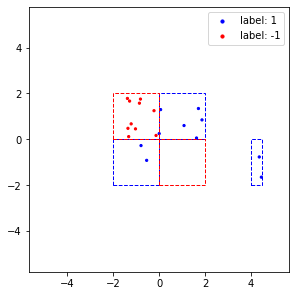

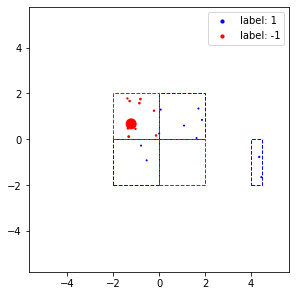

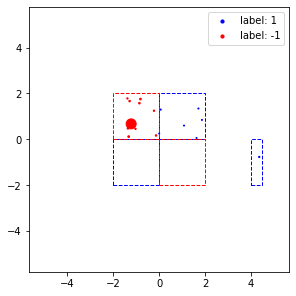

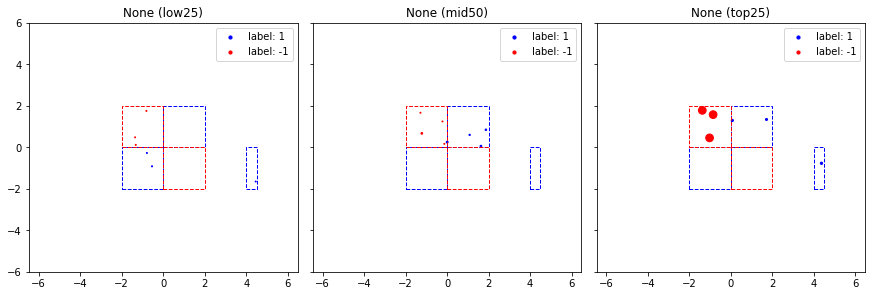

In [14]:
class UniformDataset(Dataset):
  def __init__(self, uniforms, cmap, uniforms_p={}, sizes=100, seed=0):
    self.uniforms = uniforms
    self.uniforms_p = uniforms_p
    self.cmap = cmap
    self.sizes = [sizes] * len(uniforms) if isinstance(sizes, int) else sizes
    self.seed = seed

    if self.seed is not None:
      rng = np.random.default_rng(seed)
    else:
      rng = np.random.default_rng()

    # sample n[i] data points from i-th rectangle uniformly
    datapoints = []
    for i, (label, uniform) in enumerate(uniforms.items()):
      xlow, xhigh, ylow, yhigh = rng.choice(uniform, self.sizes[i], p=self.uniforms_p[label] if label in uniforms_p else None).T
      data = zip(
          rng.uniform(xlow, xhigh, self.sizes[i]),
          rng.uniform(ylow, yhigh, self.sizes[i]),
      )
      labels = np.full(self.sizes[i], label)
      datapoints += list(zip(data, labels))

    super().__init__(datapoints)

  def _plot_data(self, axis, point_sizes, ignore=None):
    # scale relative point sizes by avg
    if not isinstance(point_sizes, np.ndarray):
      point_sizes = np.array(point_sizes)
    min, scale, max = 1, 10, 100
    point_sizes = np.clip(point_sizes * scale, min, max)

    # group data points based on labels
    dataset_grouped = defaultdict(lambda: ([],[]))
    for index, (x, label), size in zip(self.indices, self.dataset, point_sizes):
      if ignore is not None and index in ignore:
        continue
      dataset_grouped[label][0].append(x)
      dataset_grouped[label][1].append(size)
    
    # plot data points for each label separately
    for label, (datapoints, sizes) in dataset_grouped.items():
      datapoints = np.array(datapoints)
      axis.scatter(datapoints[:,0], datapoints[:,1], label="label: {}".format(label), c=self.cmap[label], s=sizes)
    
    # fix size of markers in legend
    for handle in axis.legend().legendHandles:
      handle.set_sizes([scale])
    
  def _plot_uniforms(self, axis):
    for label, uniform in self.uniforms.items():
      for xlow, xhigh, ylow, yhigh in uniform:
        axis.add_patch(Rectangle(
            xy=(xlow, ylow),
            width=xhigh - xlow,
            height=yhigh - ylow,
            edgecolor=self.cmap[label], facecolor="none", linestyle="--",
        ))

  def _plot_decision_region(self, axis, model, region, h=0.1):
    xx, yy = np.meshgrid(np.arange(region[0][0]-0.5, region[0][1]+0.5, h), np.arange(region[1][0]-0.5, region[1][1]+0.5, h))
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    y_pred = y_pred.reshape(xx.shape)
    colors = [self.cmap[label] for label in sorted(self.uniforms.keys())] # order colors by label
    axis.contourf(xx, yy, y_pred, colors=colors, alpha=0.1)

  def _plot(self, axis, plot_dataset, plot_uniforms, model, shapley_values, title=None, titlesize=12, ignore=[], ignore_sv=False):
    # plot dataset
    if plot_dataset:
      if shapley_values is not None:
        if ignore_sv:
          shapley_values_filtered = [shapley_values[i] for i in self.complement_indices(ignore)]
          avg_shapley_value = sum(shapley_values_filtered) / len(shapley_values_filtered)
        else:
          avg_shapley_value = sum(shapley_values) / len(shapley_values)
        point_sizes = shapley_values / avg_shapley_value
      else:
        point_sizes = 0.5 * np.ones(self.size)
      self._plot_data(axis, point_sizes, ignore=ignore)
    # plot Gaussian contours
    if plot_uniforms:
      self._plot_uniforms(axis)
    # plot decision regions of model
    if model is not None:
      self._plot_decision_region(axis, model, ((-6, 6), (-6, 6)))
    # set layout
    if title is not None:
      axis.set_title(title, fontsize=titlesize)
    axis.axis("equal")
    axis.set_xlim(-6, 6)
    axis.set_ylim(-6, 6)
  
  def plot(self, dataset=True, uniforms=True, model=None, shapley_values=None, title=None, titlesize=12, ignore=[], ignore_sv=False):
    fig, axis = plt.subplots(figsize=(4, 4), constrained_layout=True)
    self._plot(axis, dataset, uniforms, model, shapley_values, title=title, titlesize=titlesize, ignore=ignore, ignore_sv=ignore_sv)
    return fig
  
  def plot_splitted(self, dataset=True, uniforms=True, model=None, shapley_values=None, title=None, titlesize=12, ignore=[]):
    if shapley_values is None:
      print("WARNING: plot_splitted requires argument shapley_values")
      return

    fig, axes = plt.subplots(1, 3, figsize=(3 * 4, 4), sharey=True, constrained_layout=True)

    # group Shapley values based on labels
    shapley_values_grouped = defaultdict(lambda: ([],[]))
    for index, label, sv in zip(self.indices, self.to_matrix_form()[1], shapley_values):
      shapley_values_grouped[label][0].append(index)
      shapley_values_grouped[label][1].append(sv)

    low25, mid50, top25 = [], [], []
    for label, (indices, values) in shapley_values_grouped.items():
      size = len(values)
      quarterSize = math.ceil(len(values) / 4)
      indices_sorted = [indices[i] for i in np.argsort(values)]
      low25 += list(indices_sorted[:quarterSize])
      mid50 += list(indices_sorted[quarterSize:size - quarterSize])
      top25 += list(indices_sorted[size - quarterSize:])

    self._plot(axes[0], dataset, uniforms, model, shapley_values, title="{} (low25)".format(title), titlesize=titlesize, ignore=mid50 + top25, ignore_sv=False)
    self._plot(axes[1], dataset, uniforms, model, shapley_values, title="{} (mid50)".format(title), titlesize=titlesize, ignore=low25 + top25, ignore_sv=False)
    self._plot(axes[2], dataset, uniforms, model, shapley_values, title="{} (top25)".format(title), titlesize=titlesize, ignore=low25 + mid50, ignore_sv=False)
    
    return fig
    
  def get_params(self):
    return {
        "uniforms": self.uniforms,
        "uniforms_p": self.uniforms_p,
        "sizes": self.sizes,
        "seed": self.seed,
        **super().get_params(),
    }

if ENV == COLAB:
  uniforms = {
      1: [
          (0, 2, 0, 2),
          (-2, 0, -2, 0),
          (4, 4.5, -2, 0),
      ],
      -1: [
          (-2, 0, 0, 2),
          (0, 2, -2, 0),
      ],
  }
  uniforms_p = {
      -1: [1, 0],
  }
  cmap = {1: "blue", -1: "red"}
  dataset = UniformDataset(uniforms, cmap, uniforms_p=uniforms_p, sizes=10, seed=0)
  dataset.plot()
  dataset.plot(shapley_values=np.array(list(range(19)) + [1000]))
  dataset.plot(shapley_values=np.array(list(range(19)) + [1000]), ignore=[0,1,2])
  dataset.plot_splitted(shapley_values=np.array(list(range(10)) + [100, 100, 1, 1, 1, 100, 0, 0, 0, 5, 0]))
  print()

### replot

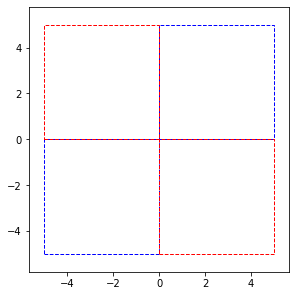

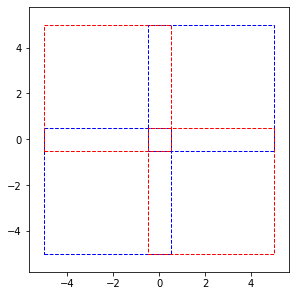

In [29]:
# datasets = [
#     {
#         "uniforms": {
#             1: [
#                 (0, 5, 0, 5),
#                 (-5, 0, -5, 0),
#             ],
#             -1: [
#                 (-5, 0, 0, 5),
#                 (0, 5, -5, 0),
#             ],
#         },
#         "cmap": {1: "blue", -1: "red"},
#     },
#     {
#         "uniforms": {
#             1: [
#                 (-0.5, 5, -0.5, 5),
#                 (-5, 0.5, -5, 0.5),
#             ],
#             -1: [
#                 (-5, 0.5, -0.5, 5),
#                 (-0.5, 5, -5, 0.5),
#             ],
#         },
#         "cmap": {1: "blue", -1: "red"},
#     },
# ]
# for i, u in enumerate(datasets, start=1):
#   dataset = UniformDataset(u["uniforms"], u["cmap"], sizes=10, seed=0)
#   fig = dataset.plot(dataset=False)
#   fig.savefig("XORDataset{}.png".format(i))

## Class: UniformExperimentA

In [15]:
class UniformExperimentA(ExperimentA):
  @staticmethod
  def get_experiment_batch(config, test_run=False):
    return [
        UniformExperimentA(
            model_constructor,
            lambda seed: UniformDataset(dataset["uniforms"], dataset["cmap"], sizes=params["train_dataset_size"] if not test_run else 5, seed=seed),
            lambda seed: UniformDataset(dataset["uniforms"], dataset["cmap"], sizes=params["test_dataset_size"] if not test_run else 100, seed=seed),
            num_permutations=params["num_permutations"] if not test_run or params["num_permutations"] is None else 10,
            seed=seed,
            name_batch="{}-{}{}".format(config["batch_id"], config["batch_name"], "" if not test_run else "-dev"),
            name_experiment="{}-{}".format(i, model_name),
        ) for i, (dataset, params, (model_name, model_constructor), seed) in enumerate(itertools.product(
            config["datasets"],
            config["params"],
            config["model_constructors"].items(),
            config["seeds"],
        ))
    ]

## Experiment A2

- Uniform 1: $([-5,0.5] \times [-5,0.5]) \cup ([-0.5,5] \times [-0.5,5])$
- Uniform 2: $([-5,0.5] \times [-0.5,5]) \cup ([-0.5,5] \times [-5,0.5])$

In [16]:
datasets = [
    {
        "uniforms": {
            1: [
                (-0.5, 5, -0.5, 5),
                (-5, 0.5, -5, 0.5),
            ],
            -1: [
                (-5, 0.5, -0.5, 5),
                (-0.5, 5, -5, 0.5),
            ],
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [17]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size200_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         # "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": "3",
#     "batch_name": "size400_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         # "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         # "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         # "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         # {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#         {"train_dataset_size": 100, "test_dataset_size": 100, "num_permutations": 10},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     UniformExperimentA.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     UniformExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     UniformExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
#     UniformExperimentA.get_experiment_batch(experiment_batch3, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [18]:
# # !rm -r /content/results/uniform_experimentA2_replot
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/uniform_experimentA2"
# OUTPUT_DIR = "/content/results/uniform_experimentA2_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("-", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order, folder)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = UniformDataset({int(label): uniform for label, uniform in config["dataset_train"]["uniforms"].items()}, datasets[0]["cmap"], sizes=config["dataset_train"]["sizes"], seed=config["dataset_train"]["seed"])
#   test_dataset = UniformDataset({int(label): uniform for label, uniform in config["dataset_test"]["uniforms"].items()}, datasets[0]["cmap"], sizes=config["dataset_test"]["sizes"], seed=config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     folders_grouped.append(DIRLIST[i:i+2])
#     i += 2

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/uniform_experimentA2_replot.zip
# !zip -q results/uniform_experimentA2_replot.zip /content/results/uniform_experimentA2_replot/*/*/*

## Experiment A1

- Uniform 1: $([-5,0] \times [-5,0]) \cup ([0,5] \times [0,5])$
- Uniform 2: $([-5,0] \times [0,5]) \cup ([0,5] \times [-5,0])$

In [19]:
datasets = [
    {
        "uniforms": {
            1: [
                (0, 5, 0, 5),
                (-5, 0, -5, 0),
            ],
            -1: [
                (-5, 0, 0, 5),
                (0, 5, -5, 0),
            ],
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [20]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size200_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         # "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": "3",
#     "batch_name": "size400_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         # "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         # "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         # {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#         {"train_dataset_size": 100, "test_dataset_size": 100, "num_permutations": 10},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     UniformExperimentA.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     UniformExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     UniformExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
#     UniformExperimentA.get_experiment_batch(experiment_batch3, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [21]:
# # !rm -r /content/results/uniform_experimentA1_replot
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/uniform_experimentA1"
# OUTPUT_DIR = "/content/results/uniform_experimentA1_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("-", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order, folder)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = UniformDataset({int(label): uniform for label, uniform in config["dataset_train"]["uniforms"].items()}, datasets[0]["cmap"], sizes=config["dataset_train"]["sizes"], seed=config["dataset_train"]["seed"])
#   test_dataset = UniformDataset({int(label): uniform for label, uniform in config["dataset_test"]["uniforms"].items()}, datasets[0]["cmap"], sizes=config["dataset_test"]["sizes"], seed=config["dataset_test"]["seed"])
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     folders_grouped.append(DIRLIST[i:i+2])
#     i += 2

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/uniform_experimentA1_replot.zip
# !zip -q results/uniform_experimentA1_replot.zip /content/results/uniform_experimentA1_replot/*/*/*

# Experiments with Gaussians

## Class: GaussianDataset

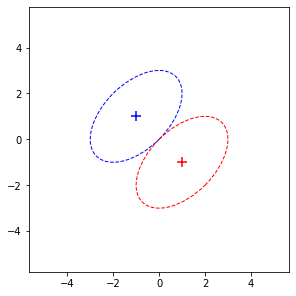

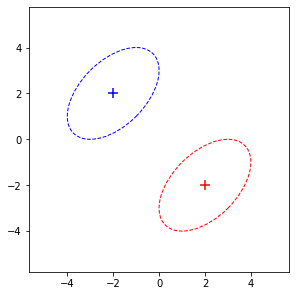

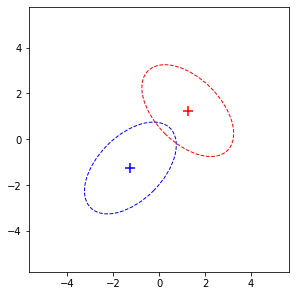

In [25]:
class GaussianDataset(Dataset):
  def __init__(self, gaussians, cmap, sizes=100, seed=0):
    self.gaussians = gaussians
    self.cmap = cmap
    self.sizes = [sizes] * len(gaussians) if isinstance(sizes, int) else sizes
    self.seed = seed

    if self.seed is not None:
      rng = np.random.default_rng(seed)
    else:
      rng = np.random.default_rng()

    # sample n[i] data points from i-th gaussian
    datapoints = []
    for i, (label, gaussian) in enumerate(gaussians.items()):
      data = rng.multivariate_normal(gaussian["mean"], gaussian["cov"], self.sizes[i])
      labels = np.full(self.sizes[i], label)
      datapoints += list(zip(data, labels))

    super().__init__(datapoints)

  def _plot_data(self, axis, point_sizes, ignore=None):
    # scale relative point sizes by avg
    if not isinstance(point_sizes, np.ndarray):
      point_sizes = np.array(point_sizes)
    min, scale, max = 1, 10, 100
    point_sizes = np.clip(point_sizes * scale, min, max)

    # group data points based on labels
    dataset_grouped = defaultdict(lambda: ([],[]))
    for index, (x, label), size in zip(self.indices, self.dataset, point_sizes):
      if ignore is not None and index in ignore:
        continue
      dataset_grouped[label][0].append(x)
      dataset_grouped[label][1].append(size)
    
    # plot data points for each label separately
    for label, (datapoints, sizes) in dataset_grouped.items():
      datapoints = np.array(datapoints)
      axis.scatter(datapoints[:,0], datapoints[:,1], label="label: {}".format(label), c=self.cmap[label], s=sizes)
    
    # fix size of markers in legend
    for handle in axis.legend().legendHandles:
      handle.set_sizes([scale])
    
  def _plot_gaussians(self, axis):
    for label, g in self.gaussians.items():
      l, v = np.linalg.eig(g["cov"])
      # plot shape of Gaussian (corresponding to standard deviation 1)
      axis.add_patch(Ellipse(
          xy=g["mean"],
          width=2 * np.sqrt(l[0]),
          height=2 * np.sqrt(l[1]),
          # angle=np.rad2deg(np.arccos(v[0, 0])),
          angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])), # TODO (assuming first eigenvalue is largest?)
          edgecolor=self.cmap[label], facecolor="none", linestyle="--",
      ))
      # plot center of Gaussian
      axis.scatter(g["mean"][0], g["mean"][1], s=100, color=self.cmap[label], marker="+")

  def _plot_decision_region(self, axis, model, region, h=0.1):
    xx, yy = np.meshgrid(np.arange(region[0][0]-0.5, region[0][1]+0.5, h), np.arange(region[1][0]-0.5, region[1][1]+0.5, h))
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    y_pred = y_pred.reshape(xx.shape)
    colors = [self.cmap[label] for label in sorted(self.gaussians.keys())] # order colors by label
    axis.contourf(xx, yy, y_pred, colors=colors, alpha=0.1)

  def _plot(self, axis, plot_dataset, plot_gaussians, model, shapley_values, title=None, titlesize=12, ignore=[], ignore_sv=False):
    # plot dataset
    if plot_dataset:
      if shapley_values is not None:
        if ignore_sv:
          shapley_values_filtered = [shapley_values[i] for i in self.complement_indices(ignore)]
          avg_shapley_value = sum(shapley_values_filtered) / len(shapley_values_filtered)
        else:
          avg_shapley_value = sum(shapley_values) / len(shapley_values)
        point_sizes = shapley_values / avg_shapley_value
      else:
        point_sizes = 0.5 * np.ones(self.size)
      self._plot_data(axis, point_sizes, ignore=ignore)
    # plot Gaussian contours
    if plot_gaussians:
      self._plot_gaussians(axis)
    # plot decision regions of model
    if model is not None:
      self._plot_decision_region(axis, model, ((-6, 6), (-6, 6)))
    # set layout
    if title is not None:
      axis.set_title(title, fontsize=titlesize)
    axis.axis("equal")
    axis.set_xlim(-6, 6)
    axis.set_ylim(-6, 6)
  
  def plot(self, dataset=True, gaussians=True, model=None, shapley_values=None, title=None, titlesize=12, ignore=[], ignore_sv=False):
    fig, axis = plt.subplots(figsize=(4, 4), constrained_layout=True)
    self._plot(axis, dataset, gaussians, model, shapley_values, title=title, titlesize=titlesize, ignore=ignore, ignore_sv=ignore_sv)
    return fig
  
  def plot_splitted(self, dataset=True, gaussians=True, model=None, shapley_values=None, title=None, titlesize=12, ignore=[]):
    if shapley_values is None:
      print("WARNING: plot_splitted requires argument shapley_values")
      return

    fig, axes = plt.subplots(1, 3, figsize=(3 * 4, 4), sharey=True, constrained_layout=True)

    # group Shapley values based on labels
    shapley_values_grouped = defaultdict(lambda: ([],[]))
    for index, label, sv in zip(self.indices, self.to_matrix_form()[1], shapley_values):
      shapley_values_grouped[label][0].append(index)
      shapley_values_grouped[label][1].append(sv)

    low25, mid50, top25 = [], [], []
    for label, (indices, values) in shapley_values_grouped.items():
      size = len(values)
      quarterSize = math.ceil(len(values) / 4)
      indices_sorted = [indices[i] for i in np.argsort(values)]
      low25 += list(indices_sorted[:quarterSize])
      mid50 += list(indices_sorted[quarterSize:size - quarterSize])
      top25 += list(indices_sorted[size - quarterSize:])

    self._plot(axes[0], dataset, gaussians, model, shapley_values, title="{} (low25)".format(title), titlesize=titlesize, ignore=mid50 + top25, ignore_sv=False)
    self._plot(axes[1], dataset, gaussians, model, shapley_values, title="{} (mid50)".format(title), titlesize=titlesize, ignore=low25 + top25, ignore_sv=False)
    self._plot(axes[2], dataset, gaussians, model, shapley_values, title="{} (top25)".format(title), titlesize=titlesize, ignore=low25 + mid50, ignore_sv=False)
    
    return fig
    
  def get_params(self):
    return {
        "gaussians": self.gaussians,
        "sizes": self.sizes,
        "seed": self.seed,
        **super().get_params(),
    }

if ENV == COLAB:
  gaussians = {
      1: {"mean": [-1.25, -1.25], "cov": [[4,2], [2,4]]},
      -1: {"mean": [1.25, 1.25], "cov": [[4,-2], [-2,4]]},
  }
  cmap = {1: "blue", -1: "red"}
  dataset = GaussianDataset(gaussians, cmap, sizes=10, seed=0)
  dataset.plot()
  dataset.plot(shapley_values=np.array(list(range(19)) + [1000]))
  dataset.plot(shapley_values=np.array(list(range(19)) + [1000]), ignore=[0,1,2])
  dataset.plot_splitted(shapley_values=np.array(list(range(10)) + [100, 100, 1, 1, 1, 100, 0, 0, 0, 5, 0]))
  print()

### replot

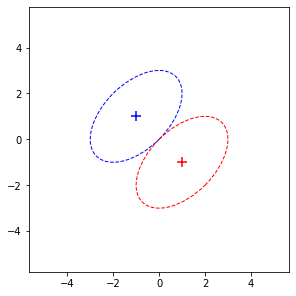

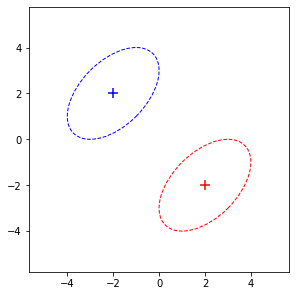

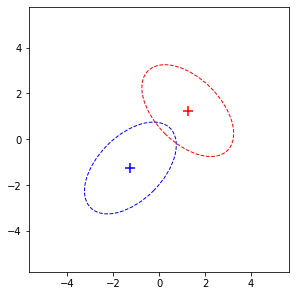

In [28]:
# datasets = [
#     {
#         "gaussians": {
#             1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
#             -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
#         },
#         "cmap": {1: "blue", -1: "red"},
#     },
#     {
#         "gaussians": {
#             1: {"mean": [-2, 2], "cov": [[4, 2], [2, 4]]},
#             -1: {"mean": [2, -2], "cov": [[4, 2], [2, 4]]},
#         },
#         "cmap": {1: "blue", -1: "red"},
#     },
#     {
#         "gaussians": {
#             1: {"mean": [-1.25, -1.25], "cov": [[4,2], [2,4]]},
#             -1: {"mean": [1.25, 1.25], "cov": [[4,-2], [-2,4]]},
#         },
#         "cmap": {1: "blue", -1: "red"},
#     },
# ]
# for i, g in enumerate(datasets, start=1):
#   dataset = GaussianDataset(g["gaussians"], g["cmap"], sizes=10, seed=0)
#   fig = dataset.plot(dataset=False)
#   fig.savefig("GaussianDataset{}.png".format(i))

## Class: GaussianExperimentA

In [ ]:
class GaussianExperimentA(ExperimentA):
  @staticmethod
  def get_experiment_batch(config, test_run=False):
    return [
        GaussianExperimentA(
            model_constructor,
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["train_dataset_size"] if not test_run else 5, seed=seed),
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["test_dataset_size"] if not test_run else 100, seed=seed),
            num_permutations=params["num_permutations"] if not test_run or params["num_permutations"] is None else 10,
            seed=seed,
            name_batch="{}-{}{}".format(config["batch_id"], config["batch_name"], "" if not test_run else "-dev"),
            name_experiment="{}-{}".format(i, model_name),
        ) for i, (dataset, params, (model_name, model_constructor), seed) in enumerate(itertools.product(
            config["datasets"],
            config["params"],
            config["model_constructors"].items(),
            config["seeds"],
        ))
    ]

## Class: GaussianExperimentB

In [ ]:
class GaussianExperimentB(ExperimentB):
  @staticmethod
  def get_experiment_batch(config, test_run=False):
    return [
        GaussianExperimentB(
            model_constructor,
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["train_dataset_size"] if not test_run else 5, seed=seed),
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["test_dataset_size"] if not test_run else 100, seed=seed),
            without_top=config["without_top"] if "without_top" in config else [],
            without_bottom=config["without_bottom"] if "without_bottom" in config else [],
            precomputed=config["precomputed"] if "precomputed" in config else None,
            num_permutations=params["num_permutations"] if not test_run or params["num_permutations"] is None else 10,
            seed=seed,
            name_batch="{}-{}{}".format(config["batch_id"], config["batch_name"], "" if not test_run else "_dev"),
            name_experiment="{}-{}".format(i, model_name),
        ) for i, (dataset, params, (model_name, model_constructor), seed) in enumerate(itertools.product(
            config["datasets"],
            config["params"],
            config["model_constructors"].items(),
            config["seeds"],
        ))
    ]

## Class: GaussianExperimentC

In [ ]:
class GaussianExperimentC(ExperimentC):
  @staticmethod
  def get_experiment_batch(config, test_run=False):
    return [
        GaussianExperimentC(
            model_constructor,
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["train_dataset_size"] if not test_run else 5, seed=seed),
            lambda seed: GaussianDataset(dataset["gaussians"], dataset["cmap"], sizes=params["test_dataset_size"] if not test_run else 100, seed=seed),
            num_permutations=params["num_permutations"] if not test_run or params["num_permutations"] is None else 10,
            seed=seed,
            name_batch="{}-{}{}".format(config["batch_id"], config["batch_name"], "" if not test_run else "_dev"),
            name_experiment="{}-{}".format(i, model_name),
        ) for i, (dataset, params, (model_name, model_constructor), seed) in enumerate(itertools.product(
            config["datasets"],
            config["params"],
            config["model_constructors"].items(),
            config["seeds"],
        ))
    ]

## Experiment C1

- Gaussian 1: $\mu_1 = \begin{pmatrix}1 \\ -1\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1 \\ 1\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": 3,
#     "batch_name": "size200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch4 = {
#     "batch_id": 4,
#     "batch_name": "size400_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         # {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": 5},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     GaussianExperimentC.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     GaussianExperimentC.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentC.get_experiment_batch(experiment_batch2, test_run=DEV),
#     GaussianExperimentC.get_experiment_batch(experiment_batch3, test_run=DEV),
#     GaussianExperimentC.get_experiment_batch(experiment_batch4, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentC1*
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentC1"
# OUTPUT_DIR = "/content/results/experimentC1_replot"

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()])

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1]
#     ignore = config["ignore"]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   for i in range(0, len(DIRLIST), 2):
#     folders = DIRLIST[i:i+2]

#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values (based on train dataset)
#     sortby = list(np.argsort(experiments[folders[1]]["shapley_values"]))

#     for folder in folders:
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentC1_replot.zip
# !zip -q results/experimentC1_replot.zip /content/results/experimentC1_replot/*/*/*

## Experiment B2

- Gaussian 1: $\mu_1 = \begin{pmatrix}1 \\ -1\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1 \\ 1\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
#     "without_bottom": [1, 2, 3],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size100_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_bottom": [1, 5, 10],
# }

# experiment_batch3 = {
#     "batch_id": 3,
#     "batch_name": "size200_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_bottom": [2, 10, 20],
# }

# experiment_batch4 = {
#     "batch_id": 4,
#     "batch_name": "size400_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_bottom": [4, 20, 40],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         # {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": 5},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_bottom": [1, 2],
#     "precomputed": "/content/results",
# }

# experiment_batches = [
#     GaussianExperimentB.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     GaussianExperimentB.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentB.get_experiment_batch(experiment_batch2, test_run=DEV),
#     GaussianExperimentB.get_experiment_batch(experiment_batch3, test_run=DEV),
#     GaussianExperimentB.get_experiment_batch(experiment_batch4, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentB2*
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentB2"
# OUTPUT_DIR = "/content/results/experimentB2_replot"

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()])

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1]
#     ignore = config["ignore"]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset with correct decision region
#     fig_dataset = train_dataset.plot(
#         model=model_constructors[model_name]().fit(*train_dataset(ignore if ignore is not None else [], complement=True).to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#         titlesize=8,
#         ignore=ignore if ignore is not None else [],
#         ignore_sv=True,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   for i in range(0, len(DIRLIST), 4):
#     folders = DIRLIST[i:i+4]

#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for folder in folders:
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           titlesize=8,
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           titlesize=8,
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentB2_replot.zip
# !zip -q results/experimentB2_replot.zip /content/results/experimentB2_replot/*/*/*

## Experiment B1

- Gaussian 1: $\mu_1 = \begin{pmatrix}1 \\ -1\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1 \\ 1\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
#     "without_top": [1, 2, 3],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_top": [1, 5, 10],
# }

# experiment_batch3 = {
#     "batch_id": 3,
#     "batch_name": "size200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_top": [2, 10, 20],
# }

# experiment_batch4 = {
#     "batch_id": 4,
#     "batch_name": "size400_approx",
#     "model_constructors": {
#         "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#         "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
#         "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_top": [4, 20, 40],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         # {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": 5},
#     ],
#     "seeds": [
#         0,
#     ],
#     "without_top": [1, 2],
# }


# experiment_batches = [
#     GaussianExperimentB.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     # GaussianExperimentB.get_experiment_batch(experiment_batch1, test_run=DEV),
#     # GaussianExperimentB.get_experiment_batch(experiment_batch2, test_run=DEV),
#     # GaussianExperimentB.get_experiment_batch(experiment_batch3, test_run=DEV),
#     # GaussianExperimentB.get_experiment_batch(experiment_batch4, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentB1*
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentB1"
# OUTPUT_DIR = "/content/results/experimentB1_replot"

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()])

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1].rsplit("_", 1)[0]
#     ignore = config["ignore"]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset with correct decision region
#     fig_dataset = train_dataset.plot(
#         model=model_constructors[model_name]().fit(*train_dataset(ignore if ignore is not None else [], complement=True).to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#         ignore=ignore if ignore is not None else [],
#         ignore_sv=True,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   for i in range(0, len(DIRLIST), 4):
#     folders = DIRLIST[i:i+4]

#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for folder in folders:
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           titlesize=10,
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           titlesize=10,
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentB1_replot.zip
# !zip -q results/experimentB1_replot.zip /content/results/experimentB1_replot/*/*/*

## Experiment A4

- Gaussian 1: $\mu_1 = \begin{pmatrix}1 \\ -1\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1 \\ 1\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "MLPClassifier1": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
    "MLPClassifier2": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=2)),
    "MLPClassifier3": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=3)),
    "MLPClassifier4": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=4)),
}

In [ ]:
# experiment_batch1 = {
#     "batch_id": 1,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#     ],
#     "seeds": [0],
# }

# experiment_batch2 = {
#     "batch_id": 2,
#     "batch_name": "size200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [0],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     GaussianExperimentA.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     GaussianExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentA4_replot
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentA4"
# OUTPUT_DIR = "/content/results/experimentA4_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("-", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   elif "GaussianExperiment_2_size100_approx" in basepath.rsplit("/", 1)[1]:
#     folder_order = (folder_id % 4) * 3 + int(folder_id / 4)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order, folder)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     if "GaussianExperiment_2_size100_approx" in DIRLIST[i]:
#       folders_grouped.append(DIRLIST[i:i+3])
#       i += 3
#     else:
#       folders_grouped.append(DIRLIST[i:i+4])
#       i += 4

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)

#       if "GaussianExperiment_2_size100_approx" in folder:
#         sortby = list(np.argsort(experiments[folders[max(i-1, 0)]]["shapley_values"]))
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentA4_replot.zip
# !zip -q results/experimentA4_replot.zip /content/results/experimentA4_replot/*/*/*

## Experiment A3

- Gaussian 1: $\mu_1 = \begin{pmatrix}1.25 \\ -1.25\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1.25 \\ 1.25\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ -1 & 1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1.25, -1.25], "cov": [[4,2], [2,4]]},
            -1: {"mean": [1.25, 1.25], "cov": [[4,-2], [-2,4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = { # 12 experiments, exact, different seeds
#     "batch_id": 1,
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch2 = { # 12 computations, approx, different num_permutations
#     "batch_id": 2,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 200},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 400},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 600},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": 3,
#     "batch_name": "size6_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 6, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch4 = {
#     "batch_id": 4,
#     "batch_name": "size8_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 8, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch5 = {
#     "batch_id": 5,
#     "batch_name": "size100_200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch6 = {
#     "batch_id": 6,
#     "batch_name": "size400_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     GaussianExperimentA.get_experiment_batch(experiment_batch_dev), # index 0 = dev experiments
#     GaussianExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch3, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch4, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch5, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch6, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentA3*
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentA3"
# OUTPUT_DIR = "/content/results/experimentA3_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("-", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   elif "GaussianExperiment-2-size100_approx" in basepath.rsplit("/", 1)[1]:
#     folder_order = (folder_id % 4) * 3 + int(folder_id / 4)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1].rsplit("_", 1)[0]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     if "GaussianExperiment-2-size100_approx" in DIRLIST[i]:
#       folders_grouped.append(DIRLIST[i:i+3])
#       i += 3
#     else:
#       folders_grouped.append(DIRLIST[i:i+4])
#       i += 4

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)

#       if "GaussianExperiment_2_size100_approx" in folder:
#         sortby = list(np.argsort(experiments[folders[max(i-1, 0)]]["shapley_values"]))
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentA3_replot.zip
# !zip -q results/experimentA3_replot.zip /content/results/experimentA3_replot/*/*/*

In [ ]:
# INPUT_DIR = "/content/results/experimentA3"
# OUTPUT_DIR = "/content/results/experimentA3_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("-", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experimentA3(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset_experimentA3():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experimentA3(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("-")[1].rsplit("_", 1)[0]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values_experimentA3():
#   print("Replotting Shapley values")

#   for i in range(0, len(DIRLIST), 4):
#     folders = DIRLIST[i:i+4]

#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experimentA3(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for folder in folders:
#       print(folder)
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
  
# replot_dataset_experimentA3()
# replot_shapley_values_experimentA3()

## Experiment A2

- Gaussian 1: $\mu_1 = \begin{pmatrix}2 \\ -2\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-2 \\ 2\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-2, 2], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [2, -2], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = { # 12 experiments, exact, different seeds
#     "batch_id": "1",
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch2 = { # 12 computations, approx, different num_permutations
#     "batch_id": "2",
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 200},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 400},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 600},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": "3",
#     "batch_name": "size6_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 6, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch4 = {
#     "batch_id": "4",
#     "batch_name": "size8_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 8, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch5 = {
#     "batch_id": "5",
#     "batch_name": "size100_200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch6 = {
#     "batch_id": "6",
#     "batch_name": "size400_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     [], # index 0 = dev experiments
#     GaussianExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch3, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch4, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch5, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch6, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentA2_replot
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentA2"
# OUTPUT_DIR = "/content/results/experimentA2_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("_", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   elif "GaussianExperiment_2_size100_approx" in basepath.rsplit("/", 1)[1]:
#     folder_order = (folder_id % 4) * 3 + int(folder_id / 4)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("_", 1)[1].rsplit("_", 1)[0]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     if "GaussianExperiment_2_size100_approx" in DIRLIST[i]:
#       folders_grouped.append(DIRLIST[i:i+3])
#       i += 3
#     else:
#       folders_grouped.append(DIRLIST[i:i+4])
#       i += 4

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)

#       if "GaussianExperiment_2_size100_approx" in folder:
#         sortby = list(np.argsort(experiments[folders[max(i-1, 0)]]["shapley_values"]))
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentA2_replot.zip
# !zip -q results/experimentA2_replot.zip /content/results/experimentA2_replot/*/*/*

## Experiment A1

- Gaussian 1: $\mu_1 = \begin{pmatrix}1 \\ -1\end{pmatrix}$ and $\Sigma_1 = V_1 \Lambda_1 V_1^T$ with $\Lambda_1 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_1 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$
- Gaussian 2: $\mu_2 = \begin{pmatrix}-1 \\ 1\end{pmatrix}$ and $\Sigma_2 = V_2 \Lambda_2 V_2^T$ with $\Lambda_2 = \begin{pmatrix}3 & 0 \\ 0 & 1\end{pmatrix}$ and $V_2 = \begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}$

In [ ]:
datasets = [
    {
        "gaussians": {
            1: {"mean": [-1, 1], "cov": [[4, 2], [2, 4]]},
            -1: {"mean": [1, -1], "cov": [[4, 2], [2, 4]]},
        },
        "cmap": {1: "blue", -1: "red"},
    },
]
model_constructors = {
    "LogisticRegression": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.LogisticRegression()),
    "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
    "SVC_rbf": lambda: svm.SVC(kernel='rbf', gamma=0.7),
    "MLPClassifier": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(10, 10), solver='lbfgs', random_state=1)),
}

In [ ]:
# experiment_batch1 = { # 12 experiments, exact, different seeds
#     "batch_id": 1,
#     "batch_name": "size10_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 10, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch2 = { # 12 computations, approx, different num_permutations
#     "batch_id": 2,
#     "batch_name": "size100_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 200},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 400},
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 600},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch3 = {
#     "batch_id": 3,
#     "batch_name": "_sze6_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 6, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch4 = {
#     "batch_id": 4,
#     "batch_name": "_sze8_exact",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 8, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#         1,
#         2,
#     ],
# }

# experiment_batch5 = {
#     "batch_id": 5,
#     "batch_name": "_sze100_200_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 100, "test_dataset_size": 1000, "num_permutations": 460},
#         {"train_dataset_size": 200, "test_dataset_size": 1000, "num_permutations": 1060},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch6 = {
#     "batch_id": "6",
#     "batch_name": "size400_approx",
#     "model_constructors": model_constructors,
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 400, "test_dataset_size": 1000, "num_permutations": 2400},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batch_dev = {
#     "batch_id": 0,
#     "batch_name": "dev",
#     "model_constructors": {
#         "LinearSVC": lambda: pipeline.make_pipeline(preprocessing.StandardScaler(), svm.LinearSVC()),
#     },
#     "datasets": datasets,
#     "params": [
#         {"train_dataset_size": 5, "test_dataset_size": 100, "num_permutations": None},
#     ],
#     "seeds": [
#         0,
#     ],
# }

# experiment_batches = [
#     GaussianExperimentA.get_experiment_batch(experiment_batch_dev, test_run=DEV), # index 0 = dev experiments
#     GaussianExperimentA.get_experiment_batch(experiment_batch1, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch2, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch3, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch4, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch5, test_run=DEV),
#     GaussianExperimentA.get_experiment_batch(experiment_batch6, test_run=DEV),
# ]
# run_experiment_batches(experiment_batches)

### replot

In [ ]:
# # !rm -r /content/results/experimentA1_replot
# # !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

# INPUT_DIR = "/content/results/experimentA1"
# OUTPUT_DIR = "/content/results/experimentA1_replot"

# def folder_order(path):
#   basepath, folder = path.rsplit("/", 1)
#   folder_id = int(folder.split("_", 1)[0])
#   if "exact" in folder:
#     folder_order = (folder_id % 3) * 4 + int(folder_id / 3)
#   elif "GaussianExperiment_2_size100_approx" in basepath.rsplit("/", 1)[1]:
#     folder_order = (folder_id % 4) * 3 + int(folder_id / 4)
#   else:
#     folder_order = folder_id
#   return (basepath, folder_order)

# DIRLIST = sorted([f2.path for f1 in os.scandir(INPUT_DIR) if f1.is_dir() for f2 in os.scandir(f1.path) if f2.is_dir()], key=folder_order)

# def load_experiment(folder):
#   # load configuration files
#   filepath_config = os.path.join(folder, "parameters")
#   with open("{}.json".format(filepath_config), "r") as file:
#     config = json.load(file)

#   # load shapley values
#   filepath_sv = os.path.join(folder, "shapley_values")
#   with open("{}.json".format(filepath_sv), "r") as file:
#     shapley_values = np.array(json.load(file))
  
#   # load datasets
#   train_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_train"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_train"]["sizes"], config["dataset_train"]["seed"])
#   test_dataset = GaussianDataset({int(label): gaussian for label, gaussian in config["dataset_test"]["gaussians"].items()}, datasets[0]["cmap"], config["dataset_test"]["sizes"], config["dataset_test"]["seed"])
  
#   return config, shapley_values, train_dataset, test_dataset

# def replot_dataset():
#   print("Replotting dataset")
  
#   for folder in DIRLIST:
#     print(folder)

#     # load experiment folder
#     config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#     experiment_name = config["experiment"].split("/")[1]
#     model_name = experiment_name.split("_", 1)[1].rsplit("_", 1)[0]
    
#     # create output folder
#     folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#     os.makedirs(folder_output, exist_ok=True)

#     # replot dataset
#     fig_dataset = train_dataset.plot_splitted(
#         model=model_constructors[model_name]().fit(*train_dataset.to_matrix_form()),
#         shapley_values=shapley_values,
#         title=experiment_name,
#     )
#     fig_dataset.savefig(os.path.join(folder_output, "plot_dataset_splitted.png"), dpi=150)
#     plt.close()

# def replot_shapley_values():
#   print("Replotting Shapley values")

#   folders_grouped = []
#   i = 0
#   while i < len(DIRLIST):
#     if "GaussianExperiment_2_size100_approx" in DIRLIST[i]:
#       folders_grouped.append(DIRLIST[i:i+3])
#       i += 3
#     else:
#       folders_grouped.append(DIRLIST[i:i+4])
#       i += 4

#   for folders in folders_grouped:
#     experiments = {}
#     y_min, y_max = float("inf"), -float("inf")
#     for folder in folders:
#       # load experiment folder
#       config, shapley_values, train_dataset, test_dataset = load_experiment(folder)
#       experiment_name = config["experiment"].split("/")[1]

#       # store relevant experiment parameters
#       experiments[folder] = {
#           "shapley_values": shapley_values,
#           "train_dataset": train_dataset,
#           "experiment_name": experiment_name,
#       }
#       y_min = min(y_min, min(shapley_values))
#       y_max = max(y_max, max(shapley_values))
    
#     # create (full) list of indices sorted according shapley values
#     sortby = list(np.argsort(experiments[folders[0]]["shapley_values"]))

#     for i, folder in enumerate(folders):
#       print(folder)

#       if "GaussianExperiment_2_size100_approx" in folder:
#         sortby = list(np.argsort(experiments[folders[max(i-1, 0)]]["shapley_values"]))
      
#       # create output folder
#       folder_output = os.path.join(OUTPUT_DIR, os.path.relpath(folder, INPUT_DIR))
#       os.makedirs(folder_output, exist_ok=True)

#       # replot shapley values (sorted by Shapley values)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby="value",
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values_sorted.png"), dpi=150)
#       plt.close()
      
#       # replot shapley values (sorted by initial list)
#       fig_shapley_values = plot_shapley_values(
#           experiments[folder]["train_dataset"],
#           experiments[folder]["shapley_values"],
#           sortby=sortby,
#           title=experiments[folder]["experiment_name"],
#           cmap=experiments[folder]["train_dataset"].cmap,
#           ylim=(y_min - abs(y_min) * 0.1, y_max + abs(y_max) * 0.1),
#       )
#       fig_shapley_values.savefig(os.path.join(folder_output, "plot_shapley_values.png"), dpi=150)
#       plt.close()
    
#     print()
  
# replot_dataset()
# replot_shapley_values()

# !rm results/experimentA1_replot.zip
# !zip -q results/experimentA1_replot.zip /content/results/experimentA1_replot/*/*/*

# Analyzing results

In [ ]:
# !unzip -u -q "/content/drive/MyDrive/Eigene Dateien/results.zip" -d "/content"

def load_shapley_values(folder):
  filepath_sv = os.path.join(folder, "shapley_values")
  with open("{}.json".format(filepath_sv), "r") as file:
    shapley_values = np.array(json.load(file))
  return shapley_values

def compute_shapley_vector_distances(basefolder, models, start=0):
  folders = [(model, basefolder.format(i, model)) for i, model in enumerate(models, start=start)]
  for i, (model1, folder1) in enumerate(folders):
    for j, (model2, folder2) in enumerate(folders):
      if i >= j:
        continue
      
      sv1 = load_shapley_values(folder1)
      sv2 = load_shapley_values(folder2)

      sv1_sorted = np.sort(sv1)
      sv2_sorted = np.sort(sv2)
      
      print("{:20} vs. {:20}: {:.8f}, {:.8f}, {:8f} // {:.8f}, {:.8f}, {:8f}".format(
          model1,
          model2,
          np.linalg.norm(sv1 - sv2),
          scipy.spatial.distance.cosine(sv1, sv2),
          np.average(np.abs(sv1 - sv2)),
          np.linalg.norm(sv1_sorted - sv2_sorted),
          scipy.spatial.distance.cosine(sv1_sorted, sv2_sorted),
          np.average(np.abs(sv1_sorted - sv2_sorted)),
      ))
  print()

compute_shapley_vector_distances("/content/results/experimentA1/GaussianExperiment_5_size100_200_approx/{}_{}_approx460", ["LogisticRegression", "LinearSVC", "SVC_rbf", "MLPClassifier"])
compute_shapley_vector_distances("/content/results/experimentA1/GaussianExperiment_5_size100_200_approx/{}_{}_approx1060", ["LogisticRegression", "LinearSVC", "SVC_rbf", "MLPClassifier"], start=4)
compute_shapley_vector_distances("/content/results/experimentA1/GaussianExperiment_6_size400_approx/{}_{}_approx2400", ["LogisticRegression", "LinearSVC", "SVC_rbf", "MLPClassifier"])

LogisticRegression   vs. LinearSVC           : 0.01266791, 0.01674547, 0.000680 // 0.00262966, 0.00071937, 0.000135
LogisticRegression   vs. SVC_rbf             : 0.02828112, 0.07518687, 0.001450 // 0.01406644, 0.01674712, 0.000489
LogisticRegression   vs. MLPClassifier       : 0.04653814, 0.14643329, 0.002003 // 0.03532524, 0.07160225, 0.001088
LinearSVC            vs. SVC_rbf             : 0.02954765, 0.08232659, 0.001543 // 0.01500724, 0.01929620, 0.000543
LinearSVC            vs. MLPClassifier       : 0.04333615, 0.12276842, 0.001824 // 0.03588106, 0.07452012, 0.001146
SVC_rbf              vs. MLPClassifier       : 0.03862693, 0.09809477, 0.001874 // 0.02333813, 0.02609605, 0.000658

LogisticRegression   vs. LinearSVC           : 0.00815406, 0.01442315, 0.000315 // 0.00209283, 0.00093770, 0.000056
LogisticRegression   vs. SVC_rbf             : 0.02168959, 0.08565151, 0.000774 // 0.01223304, 0.02301557, 0.000377
LogisticRegression   vs. MLPClassifier       : 0.03033545, 0.13341143, 

# Toy example

In [ ]:
# # example taken from https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
# class ToyUtility(Utility):
#   def __init__(self):
#     self.utilities = {
#         ("Abhiraj",): 560,
#         ("Pranav",): 700,
#         ("Ram",): 800,
#         ("Abhiraj", "Pranav",): 720,
#         ("Abhiraj", "Ram",): 800,
#         ("Pranav", "Ram",): 850,
#         ("Abhiraj", "Pranav", "Ram",): 900,
#     }
    
#   def compute_utility(self, subset):
#     return self.utilities[tuple(sorted(subset.dataset))]

# dataset = Dataset(["Ram", "Abhiraj", "Pranav"], None)
# utility = ToyUtility()
# solver = DataShapleySolver(dataset, utility)

# solver.compute_shapley()
# solver.print_results()

# solver.approximate_shapley(n_permutations=1000)
# solver.print_results()